# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(0, 2242)
Wall time: 222 ms


,record,fraud_label,age_when_apply,dow_risk,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,...,min_age_by_ssn_zip5,max_age_by_ssn_homephone,mean_age_by_ssn_homephone,min_age_by_ssn_homephone,max_age_by_ssn_name,mean_age_by_ssn_name,min_age_by_ssn_name,max_age_by_ssn_fulladdress,mean_age_by_ssn_fulladdress,min_age_by_ssn_fulladdress


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'fulladdress_day_since',
 'name_dob_count_30',
 'address_unique_count_for_name_homephone_60',
 'fulladdress_unique_count_for_dob_homephone_3',
 'address_unique_count_for_homephone_name_dob_30',
 'address_unique_count_for_ssn_name_dob_14',
 'address_day_since',
 'address_count_14',
 'address_count_7',
 'address_count_0_by_30',
 'address_unique_count_for_homephone_name_dob_60',
 'fulladdress_count_0_by_30',
 'address_unique_count_for_ssn_zip5_60',
 'address_unique_count_for_ssn_name_60',
 'address_unique_count_for_ssn_firstname_60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0


In [5]:
vars.shape

(1000000, 17)

In [6]:
vars['Fraud'].sum()

14393.0

In [7]:
vars.head(10)

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
5,6.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
6,7.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
7,8.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
8,9.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
9,10.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0


In [8]:
vars.shape

(1000000, 17)

In [9]:
vars.describe()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754,1.063893,1.063768
std,288675.278933,0.119104,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405,0.699542,0.699434
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000,1.000000,1.000000
25%,250000.750000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
50%,500000.500000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
75%,750000.250000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754,1.063893,1.063768
std,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405,0.699542,0.699434
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000,1.000000,1.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
max,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,-4.623209e-14,3.451346e-14,-8.867842e-14,1.657446e-14,-7.463379e-14,-3.191538e-14,-5.907877e-13,5.280565e-14,2.188792e-14,-6.455372e-14,-3.886573e-14,-1.440218e-13,8.258327e-14,4.694062e-14,-6.385813e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.280209e+00,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,-3.053486e+00,-8.860966e-02,-7.268319e-02,-8.752323e+00,-9.920487e-02,-9.942674e+00,-9.115457e-02,-9.133546e-02,-9.117084e-02
25%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02
50%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02
75%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02
max,4.030326e-01,6.630026e+01,4.127016e+01,5.368356e+01,4.512894e+01,4.767899e+01,4.281212e-01,4.683076e+01,4.943321e+01,2.002135e-01,4.111004e+01,1.800485e-01,4.137264e+01,4.136435e+01,4.137092e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [19]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 15)

Wall time: 384 ms


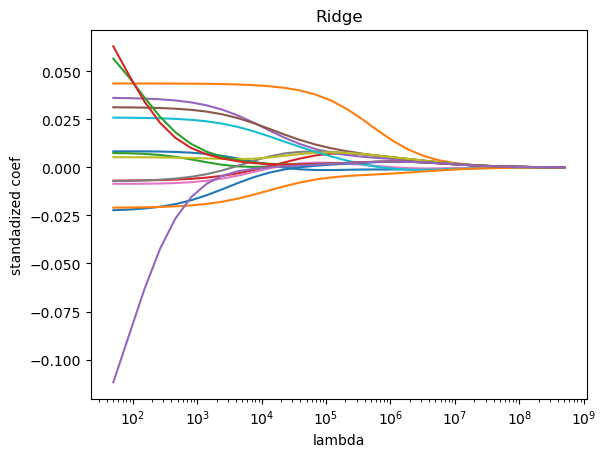

In [20]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [21]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [22]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.433e+02, tolerance: 8.260e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e+02, tolerance: 8.260e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.272e+01, toleranc

Selected Features: []
Wall time: 4min 24s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


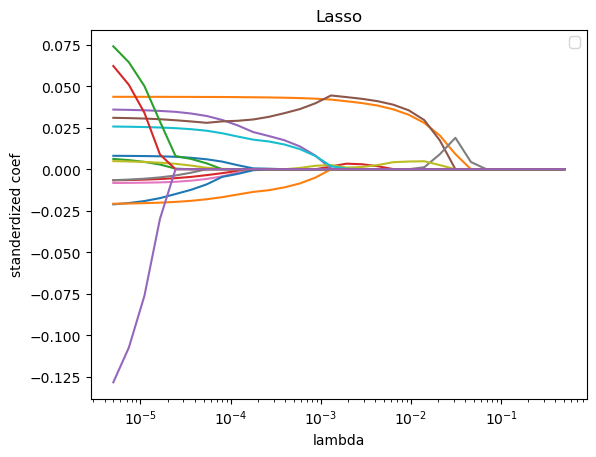

In [23]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [24]:
len(X_trntst.columns)

15

In [25]:
X_trntst_save = X_trntst.copy()

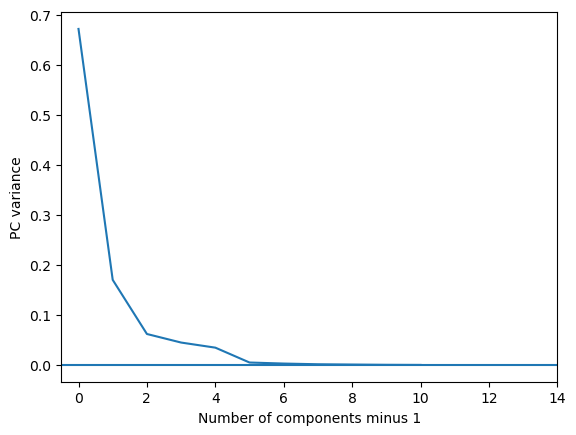

In [26]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [27]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
1,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
2,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
3,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
4,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323


In [28]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
833507,0.102589,-1.833759,-1.524099,1.514492,0.119382,0.018427
833508,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
833509,2.445230,-7.745104,1.124075,-1.534624,-1.067696,0.015400
833510,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
833511,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323


In [29]:
X_trntst.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.031522,-0.001708,-0.000377,0.001320,0.000348,0.000852,0.031615,0.000682,0.001052,0.000987,-0.000473,0.000686,-0.000253,-0.000254,-0.000254
std,0.981263,0.979550,0.996756,1.013675,1.002736,1.008244,0.983233,1.007653,1.011013,0.997512,0.996709,0.998151,0.997370,0.997336,0.997358
min,-3.280209,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,-3.053486,-0.088610,-0.072683,-8.752323,-0.099205,-9.942674,-0.091155,-0.091335,-0.091171
25%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171
50%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171
75%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171
max,0.403033,66.300262,41.270156,53.683556,45.128940,47.678988,0.428121,46.830762,49.433212,0.200213,41.110043,0.180049,41.372637,41.364353,41.370917


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.037308,-0.195574,-0.122984,0.129292,0.026586,-0.000176
std,3.089476,1.654419,1.102289,0.921288,0.803074,0.310022
min,-0.398339,-17.945408,-3.347276,-7.386734,-11.108624,-4.181878
25%,-0.398339,-0.196839,0.052509,-0.138054,-0.047243,0.012323
50%,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
75%,-0.238553,0.500547,0.127912,-0.138054,-0.041712,0.012323
max,138.123706,31.522204,47.058135,26.698606,38.975530,14.879055


In [31]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [32]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,-1.400356e-13,-2.563730e-13,-1.455268e-12,6.034793e-13,3.913865e-13,5.188504e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.257343e-01,-1.366360e+01,-3.848354e+00,-1.047926e+01,-1.501337e+01,-1.780839e+01
25%,-1.257343e-01,3.135366e-01,1.324184e-01,-1.677122e-01,-6.517187e-02,4.309251e-02
50%,-1.257343e-01,3.135366e-01,1.324184e-01,-1.677122e-01,-6.517187e-02,4.309251e-02
75%,-1.257343e-01,3.135366e-01,1.324184e-01,-1.677122e-01,-6.517187e-02,4.309251e-02
max,4.349889e+01,2.029418e+01,5.739172e+01,3.825600e+01,5.763931e+01,5.840012e+01


In [33]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.011776,-0.122505,-0.127317,0.157068,0.036676,-0.000614
std,0.975182,1.036308,1.141125,1.119207,1.107843,1.084165
min,-0.125734,-11.240781,-3.465206,-8.973613,-15.324384,-14.624252
25%,-0.125734,-0.123297,0.054359,-0.167712,-0.065172,0.043093
50%,-0.125734,0.313537,0.132418,-0.167712,-0.065172,0.043093
75%,-0.075298,0.313537,0.132418,-0.167712,-0.057542,0.043093
max,43.598250,19.745118,48.716072,32.434222,53.766874,52.032860


In [34]:
X_trntst_pca.shape

(833507, 6)

In [35]:
X_oot_orig_pca.shape

(166493, 6)

## Subsample the larger class if desired

In [36]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 15) 23841


In [37]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [39]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [39]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0 0.4803863121497556 0.4723756906077348 0.4639564124056999


C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 0.4792112140650986 0.47506269155753694 0.4631181894383906


C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 0.48018454986395365 0.47158131682611143 0.46269907795473597


C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 0.48105475709704243 0.47185061315496096 0.46437552388935455


C:\Users\yasmi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4 0.47811087318581963 0.4818106081643988 0.46437552388935455
trn    0.479790
tst    0.474536
oot    0.463705
dtype: float64
Wall time: 18.8 s


In [40]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=2,min_samples_split=1000,min_samples_leaf=500)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.46157529327268376 0.4596222283055023 0.4438390611902766
1 0.46358395105306505 0.4546750285062714 0.4438390611902766
2 0.4608157926031633 0.46303501945525294 0.4438390611902766
3 0.4610554280883951 0.4632313472893183 0.4438390611902766
4 0.457034490932796 0.4689075630252101 0.4438390611902766
trn    0.460813
tst    0.461894
oot    0.443839
dtype: float64
Wall time: 8.27 s


In [44]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=50,max_depth=15,min_samples_split=100,min_samples_leaf=50)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5280445867425589 0.5293788472299944 0.5025146689019279
1 0.5331759149940968 0.5190839694656488 0.5054484492875104
2 0.5240019011406845 0.5407964355332776 0.5029337803855826
3 0.5317516525023607 0.5213578500707213 0.5020955574182733
4 0.528176533396607 0.5307434320849637 0.501257334450964
trn    0.529030
tst    0.528272
oot    0.502850
dtype: float64
Wall time: 1min


In [42]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5141492537313432 0.5063325991189427 0.4895222129086337
1 0.5117857142857143 0.5151095092874965 0.4895222129086337
2 0.5125029768992617 0.5109448600720421 0.4895222129086337
3 0.5132124659319824 0.508127802690583 0.4895222129086337
4 0.5137823585810163 0.5099645099645099 0.4895222129086337
trn    0.513087
tst    0.510096
oot    0.489522
dtype: float64
Wall time: 11.3 s


In [43]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.49475566150178785 0.5020735416090683 0.4823973176865046
1 0.5070271557884707 0.4945998338410413 0.48826487845766975
2 0.5062245630835528 0.5157404872707364 0.4920368818105616
3 0.49057509905150676 0.4809679173463839 0.4740150880134116
4 0.4901124925991711 0.4901740595171252 0.47778709136630343
trn    0.497739
tst    0.496711
oot    0.482900
dtype: float64
Wall time: 3min 27s


In [44]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5047585058291696 0.5184670924743127 0.4920368818105616
1 0.5100238663484487 0.5260545905707196 0.490360435875943
2 0.4823529411764706 0.49638084632516705 0.47359597652975693
3 0.49102579341495306 0.48636616583194214 0.47569153394803015
4 0.5002394636015326 0.5028727770177839 0.4853310980720872
trn    0.497680
tst    0.506028
oot    0.483403
dtype: float64
Wall time: 3min 12s


In [45]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=2,n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.49798482693219537 0.4962195463455615 0.480720871751886
1 0.49912044095226926 0.49166666666666664 0.4790444258172674
2 0.49689737470167067 0.4918665563826854 0.47778709136630343
3 0.4970138557095079 0.4921595598349381 0.47778709136630343
4 0.4927449334452572 0.5005452562704471 0.47778709136630343
trn    0.496752
tst    0.494492
oot    0.478625
dtype: float64
Wall time: 19.9 s


In [46]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.49712299208822824 0.49495225102319235 0.47611064543168485
1 0.49569321533923305 0.49971687429218575 0.48113998323554064
2 0.4958263772954925 0.4965479149406241 0.4765297569153395
3 0.5013107721639657 0.48575380359612724 0.47611064543168485
4 0.5001194457716197 0.48665749656121043 0.4786253143336127
trn    0.498015
tst    0.492726
oot    0.477703
dtype: float64
Wall time: 9.88 s


In [47]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

68.41842258682435
0 0.5092862496876822 0.5092862496876822 0.48365465213746855
1 0.5055384359123845 0.5055384359123845 0.48281642917015927
2 0.5201132672607646 0.5201132672607646 0.48365465213746855
3 0.5149496127259099 0.5149496127259099 0.48281642917015927
4 0.5050387274090115 0.5050387274090115 0.48197820620285
trn    0.510985
tst    0.510985
oot    0.482984
dtype: float64
Wall time: 8.84 s


In [48]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5121462264150943 0.5058123050751346 0.49077954735959767
1 0.5128794291933728 0.5082932049224184 0.49161777032690696
2 0.5110952040085899 0.5064827586206897 0.48742665549036046
3 0.5147552783109405 0.5072187414873331 0.49245599329421624
4 0.5058111954459203 0.525034965034965 0.4911986588432523
trn    0.511337
tst    0.510568
oot    0.490696
dtype: float64
Wall time: 7.21 s


In [49]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.4716193656093489 0.47334990334161836 0.4538977367979883
1 0.4744092150575941 0.4668153931957613 0.4538977367979883
2 0.46815362595419846 0.4813690311896219 0.4538977367979883
3 0.4697946513849093 0.47727898650509504 0.4538977367979883
4 0.4732185557149689 0.46966785616250345 0.4538977367979883
trn    0.471439
tst    0.473696
oot    0.453898
dtype: float64
Wall time: 4.09 s


In [50]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=2, n_estimators=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.49577028476111046 0.48976203652462647 0.47611064543168485
1 0.4929307452671939 0.4944004370390604 0.47611064543168485
2 0.4902264600715137 0.5109206524744263 0.47611064543168485
3 0.4978743504959849 0.4913817462560045 0.47778709136630343
4 0.4900574988021083 0.4993167532112599 0.47611064543168485
trn    0.493372
tst    0.497156
oot    0.476446
dtype: float64
Wall time: 12.2 s


In [51]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [53]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.480386,0.472376,0.463956
1,log reg,0.479211,0.475063,0.463118
2,log reg,0.480185,0.471581,0.462699
3,log reg,0.481055,0.471851,0.464376
4,log reg,0.478111,0.481811,0.464376
5,DT,0.461575,0.459622,0.443839
6,DT,0.463584,0.454675,0.443839
7,DT,0.460816,0.463035,0.443839
8,DT,0.461055,0.463231,0.443839
9,DT,0.457034,0.468908,0.443839


In [54]:
df.shape

(60, 4)

In [55]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.480386
1,log reg,Trn,0.479211
2,log reg,Trn,0.480185
3,log reg,Trn,0.481055
4,log reg,Trn,0.478111


In [56]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.480386
1,log reg,Trn,0.479211
2,log reg,Trn,0.480185
3,log reg,Trn,0.481055
4,log reg,Trn,0.478111


In [57]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT  \
                           mean       std      mean       std      mean   
Model                                                                     
DT                     0.460813  0.002377  0.461894  0.005233  0.443839   
GBC                    0.496752  0.002412  0.494492  0.003871  0.478625   
LGBM                   0.513087  0.000957  0.510096  0.003313  0.489522   
NN                     0.497739  0.008317  0.496711  0.013095  0.482900   
NN_PCs                 0.497680  0.011048  0.506028  0.016166  0.483403   
RF                     0.486800  0.014133  0.486312  0.016204  0.468483   
XGB                    0.493372  0.003431  0.497156  0.008511  0.476446   
cat boost              0.498015  0.002563  0.492726  0.006202  0.477703   
cat boost_PCs          0.511337  0.003366  0.510568  0.008139  0.490696   
cat boost_sampled      0.510985  0.006461  0.510985  0.006461  0.482984   
log reg                0.479790  0.001147  0.474536  0.004296  0.463705   
unsupervised outliers  0.471439  0.002526  0.473696  0.005818  0.453898   

                                 
                            std  
Model                            
DT                     0.000000  
GBC                    0.001292  
LGBM                   0.000000  
NN                     0.007376  
NN_PCs                 0.008401  
RF                     0.010450  
XGB                    0.000750  
cat boost              0.002186  
cat boost_PCs          0.001930  
cat boost_sampled      0.000701  
log reg                0.000761  
unsupervised outliers  0.000000

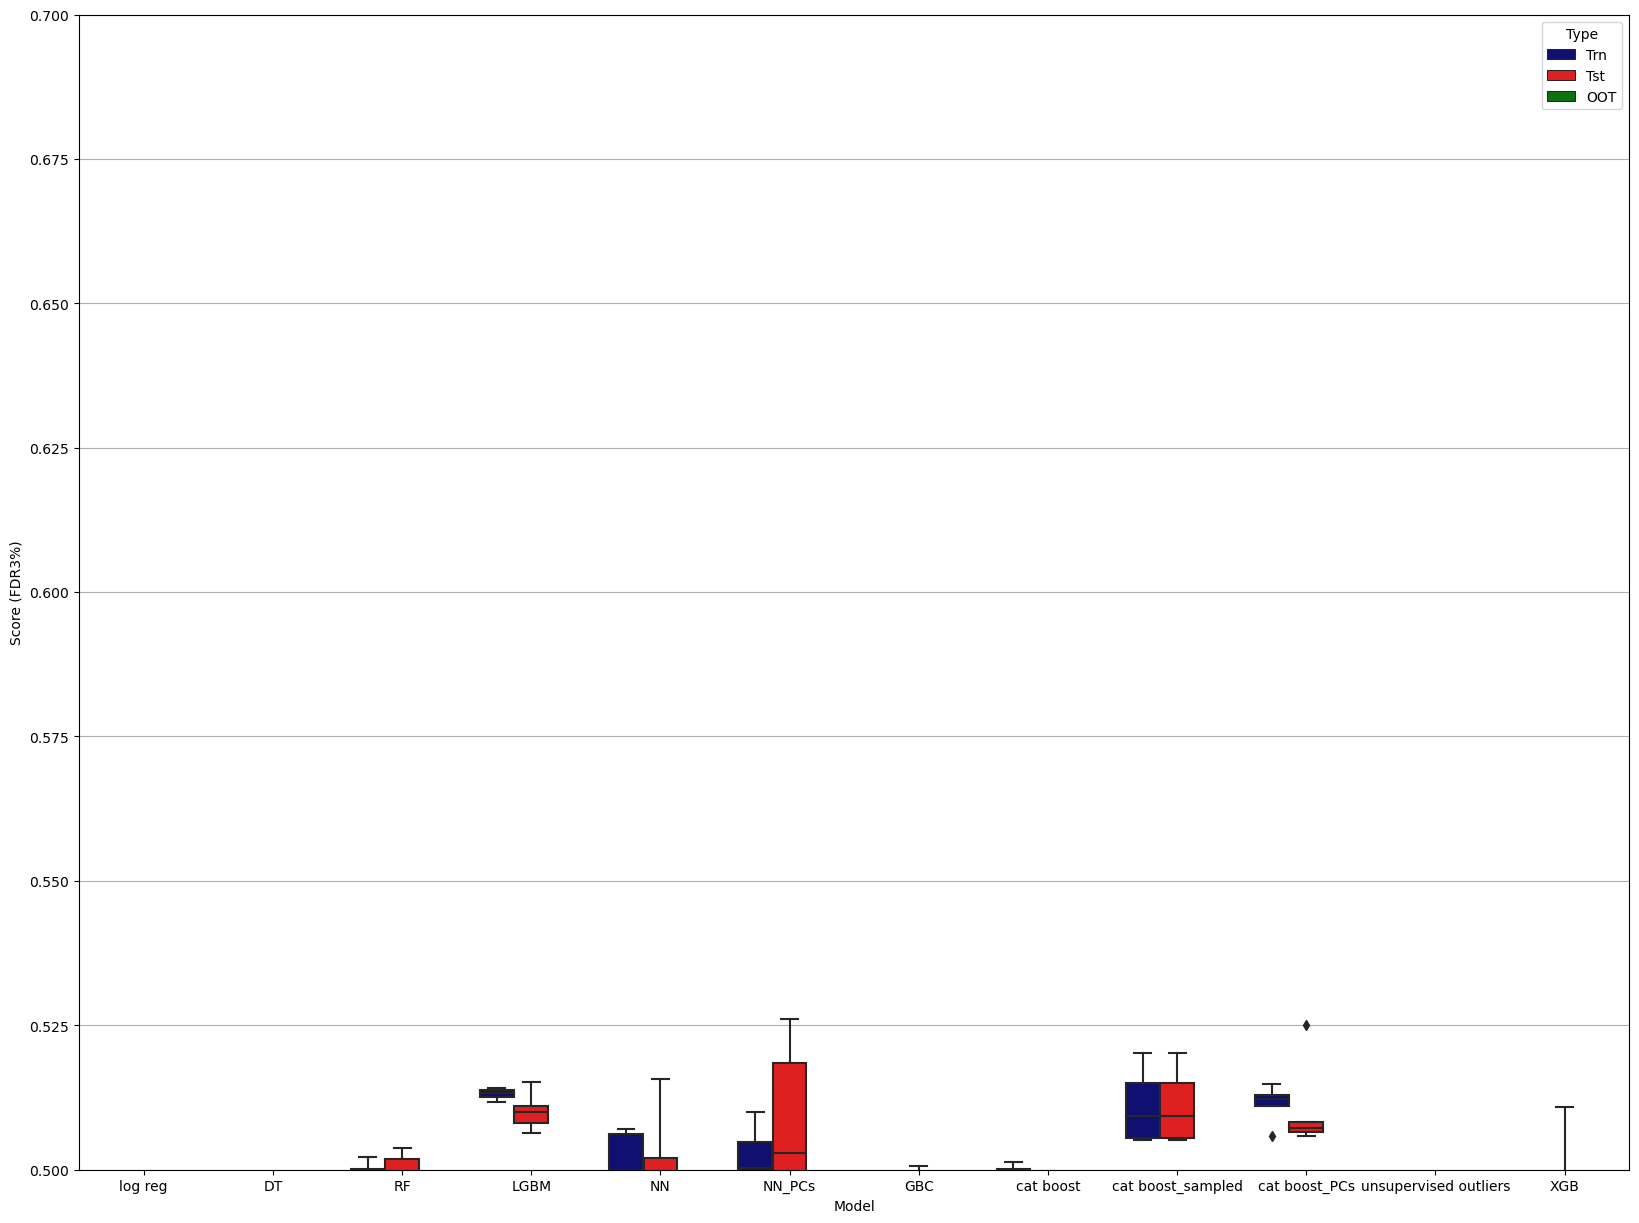

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [59]:
print('duration: ', datetime.now() - start_time)

duration:  0:16:14.245826


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [45]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = CatBoostClassifier(verbose=0, iterations=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5284379803712901 0.5261971830985915 0.5041911148365466
1 0.529108150282079 0.5250272034820457 0.5046102263202011
2 0.5286944045911047 0.527587153444963 0.5067057837384744
3 0.525105358217941 0.5345759049162615 0.5041911148365466
4 0.5337547709923665 0.5161468396356611 0.5041911148365466
5 0.5253066571394546 0.5349030470914128 0.5058675607711651
6 0.5253855278766311 0.5348057031031591 0.5058675607711651
7 0.5281530185295875 0.528555738605162 0.508382229673093
8 0.5224321133412042 0.5419847328244275 0.5054484492875104
9 0.5298819038530359 0.5217991169977925 0.5041911148365466
10 0.5269368295589988 0.5311031241360243 0.5058675607711651
11 0.5309155766944114 0.5207117041979428 0.5062866722548198
12 0.5274542429284526 0.5301976064569998 0.5088013411567477
13 0.5264594209776934 0.5308745459625593 0.5058675607711651
14 0.532769304099142 0.5150760719225449 0.5046102263202011
15 0.52933476139474 0.5252497225305216 0.5062866722548198
16 0.5313422264195491 0.5197963800904978 0.504191114836546

In [46]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [47]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,predicted,Fraud
909416,-3.199481,16.002093,-0.094684,-0.052528,-0.082437,-0.069436,-2.977176,4.765118,-0.072683,-8.119316,-0.099205,-9.226926,-0.091155,-0.091335,-0.091171,0.999726,1.0
943613,-3.229754,16.002093,-0.094684,-0.052528,-0.082437,-0.069436,-3.005792,4.765118,1.634417,-8.119316,-0.099205,-9.226926,-0.091155,-0.091335,-0.091171,0.999696,1.0
880299,-3.209572,16.002093,-0.094684,-0.052528,-0.082437,-0.069436,-2.986715,8.000937,1.634417,-8.119316,-0.099205,-9.226926,-0.091155,-0.091335,-0.091171,0.999672,1.0
931201,-3.239845,16.002093,-0.094684,-0.052528,-0.082437,-0.069436,-3.015331,3.147209,1.634417,-8.119316,-0.099205,-9.226926,-0.091155,-0.091335,-0.091171,0.999659,1.0
980888,-3.270118,1.918606,18.448175,24.036061,20.184732,21.335030,-3.043947,20.944212,22.119615,-8.490723,18.373906,-9.646880,18.496062,18.492249,18.495282,0.999601,1.0
998070,-3.280209,-0.093321,24.153671,22.183093,26.420784,27.921019,-3.053486,27.415850,28.948014,-8.119316,24.057940,-9.226926,24.215206,24.210275,24.214191,0.999573,1.0
915315,-3.280209,-0.093321,28.432792,24.036061,29.538810,31.214014,-3.053486,30.651669,28.948014,-8.223310,28.320966,-9.344513,28.504564,28.498794,28.503372,0.999573,1.0
923284,-3.270118,-0.093321,22.727297,14.771219,23.302758,24.628024,-3.043947,24.180031,22.119615,-8.574290,22.636932,-9.741370,22.785420,22.780768,22.784464,0.999568,1.0
939924,-3.270118,-0.093321,21.300923,27.741998,23.302758,24.628024,-3.043947,24.180031,25.533814,-8.574290,21.215923,-9.741370,21.355634,21.351262,21.354737,0.999568,1.0
997377,-3.270118,-0.093321,22.727297,20.330125,24.861771,26.274522,-3.043947,25.797940,27.240914,-8.608700,22.636932,-9.780277,22.785420,22.780768,22.784464,0.999568,1.0


In [48]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,508.0,1157.0,30.510511,69.489489,1665.0,508.0,1157.0,0.309554,48.491199,48.181645,0.439067
2,2.0,1665.0,1638.0,27.0,98.378378,1.621622,3330.0,2146.0,1184.0,1.307683,49.622800,48.315116,1.812500
3,3.0,1665.0,1643.0,22.0,98.678679,1.321321,4995.0,3789.0,1206.0,2.308859,50.544845,48.235985,3.141791
4,4.0,1665.0,1648.0,17.0,98.978979,1.021021,6660.0,5437.0,1223.0,3.313082,51.257334,47.944252,4.445626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1655.0,10.0,99.399399,0.600601,159833.0,157491.0,2342.0,95.968484,98.155909,2.187425,67.246371
97,97.0,1665.0,1654.0,11.0,99.339339,0.660661,161498.0,159145.0,2353.0,96.976363,98.616932,1.640569,67.634934
98,98.0,1665.0,1653.0,12.0,99.279279,0.720721,163163.0,160798.0,2365.0,97.983633,99.119866,1.136233,67.990698
99,99.0,1665.0,1656.0,9.0,99.459459,0.540541,164828.0,162454.0,2374.0,98.992730,99.497066,0.504336,68.430497


In [49]:
FDR3.to_csv('FDR3.csv')

In [50]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [51]:
print("duration: ", datetime.now() - start_time)

duration:  0:28:30.201395
